# Facial keypoints regression

## 1. EDA

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
import collections
import random
import albumentations as A
import cv2
import tensorflow as tf

In [242]:
raw_data = pd.read_csv("../train.csv")

In [243]:
column_names = raw_data.columns

In [244]:
raw_data.shape

(5000, 29)

In [245]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,5000.0,55.8784,75.090951,0.0,19.0,32.0,59.00,995.0
y1,5000.0,65.8902,84.338347,2.0,22.0,38.0,71.00,1115.0
x2,5000.0,109.4142,135.409101,10.0,38.0,64.0,116.00,1726.0
y2,5000.0,62.8678,77.680322,5.0,21.0,37.0,68.00,1107.0
x3,5000.0,165.7338,200.658416,16.0,58.0,99.0,177.00,2389.0
y3,5000.0,62.2466,78.322560,6.0,21.0,37.0,66.00,1033.0
x4,5000.0,221.8206,268.747151,14.0,77.0,133.0,237.00,3306.0
y4,5000.0,62.5374,84.230153,2.0,20.0,35.0,66.00,1041.0
x5,5000.0,70.1150,88.257199,6.0,24.0,41.0,73.00,1040.0
y5,5000.0,88.2118,106.491293,7.0,31.0,53.0,95.00,1353.0


Let's check for missing values

In [246]:
raw_data.isnull().any().value_counts()

False    29
dtype: int64

## 2. Loading and preprocessing images

In [4]:
IMG_SIZE = 96
_dir_train = "../train/"
_dir_test = "../test/"

In [248]:
def get_facial_pts(filename):
    """Returns corresponding keypoints as numpy array of shape 28"""
    return raw_data[raw_data['filename']==filename].values[0][1:]

I'm using albumentations lib for transforming both images and keypoints

In [249]:
resize_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], keypoint_params=A.KeypointParams(format='xy'))

In [250]:
def get_train_data():
    """
    Uploading, normalizing and resizing images and keypoints
    Returns: array of images (5000,96,96,3), array of keypoints (5000,28)
    """
    train_images = []
    train_keypoints = []
    for file in os.listdir(_dir_train):
        img = cv2.imread(_dir_train + str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # We normalize data
        img = (img / 255).astype(np.float32)

        facial_pts = get_facial_pts(str(file))
        facial_pts.resize((14, 2))

        resized = resize_transform(image=img, keypoints=facial_pts)
        resized_image = resized['image']
        resized_keypoints = resized['keypoints']

        train_images.append(resized_image)
        train_keypoints.append(resized_keypoints)
        
    return np.array(train_images),np.array(train_keypoints)

In [251]:
train_images,train_keypoints = get_train_data()

In [252]:
train_keypoints = train_keypoints.reshape((train_keypoints.shape[0],28))
train_images.shape,train_keypoints.shape

((5000, 96, 96, 3), (5000, 28))

In [253]:
def plot_samples(images,points=None):
    """
    Inputs: array of images, array of keypoints
    Outputs: subplots of images with keypoints
    """
    random_indices =  [random.randint(0, len(images)) for i in range(9)]
    plt.figure(figsize=(10,10))
    for i, index in enumerate(random_indices):
        plt.subplot(3,3,i+1)
        plt.imshow(images[index])
        if(points is not None):
            plt.scatter(points[index][0::2], points[index][1::2], c='red', marker='x')
        plt.tight_layout()       

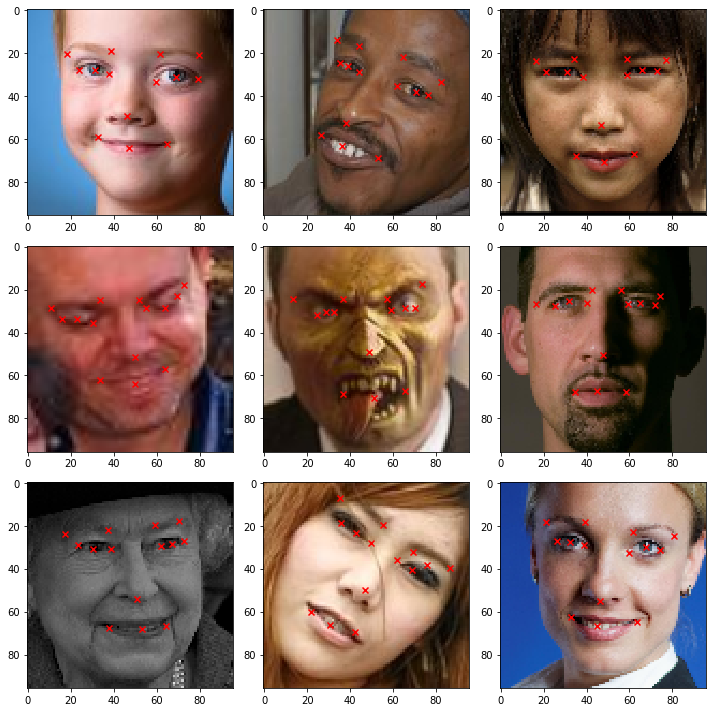

In [254]:
plot_samples(train_images,train_keypoints)

In [255]:
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
import math

In [256]:
class DataLoader(Sequence):
    """
    Base class for fitting to a sequence of data, such as a dataset.
    Every Sequence must implement the __getitem__ and the __len__ methods.
    """
    
    def __init__(self, x_set, y_set, batch_size,augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.aug = augmentations
        
    def __len__(self):
        """Number of batch in the Sequence."""
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        """
        Gets batch at position idx
        If we have augmentations, we apply them to batch
        """
        batch_x = self.x[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size: (idx+1)*self.batch_size]
        
        if self.aug is not None:
            keypoints = np.array([ tuple(zip(point[::2], point[1::2])) for point in batch_y ])
            transformed = [ self.aug(image=x, keypoints=y) for x,y in zip(batch_x, keypoints) ]
            batch_x = np.concatenate([batch_x,[aug['image'] for aug in transformed ]], axis=0)
            batch_y = np.concatenate([batch_y,[np.array(aug['keypoints']).reshape(-1) for aug in transformed]], axis=0)

        return batch_x, batch_y

In [257]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_keypoints, test_size=0.2, random_state=15,shuffle=True)
X_train.shape,y_train.shape,X_valid.shape

((4000, 96, 96, 3), (4000, 28), (1000, 96, 96, 3))

Augmentation pipline

In [258]:
transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=30,p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(1e-5, 1e-3), p=0.5),
],keypoint_params=A.KeypointParams(format='xy',remove_invisible=False,)
)

train_loader = DataLoader(X_train,y_train,batch_size=128,augmentations=transform)

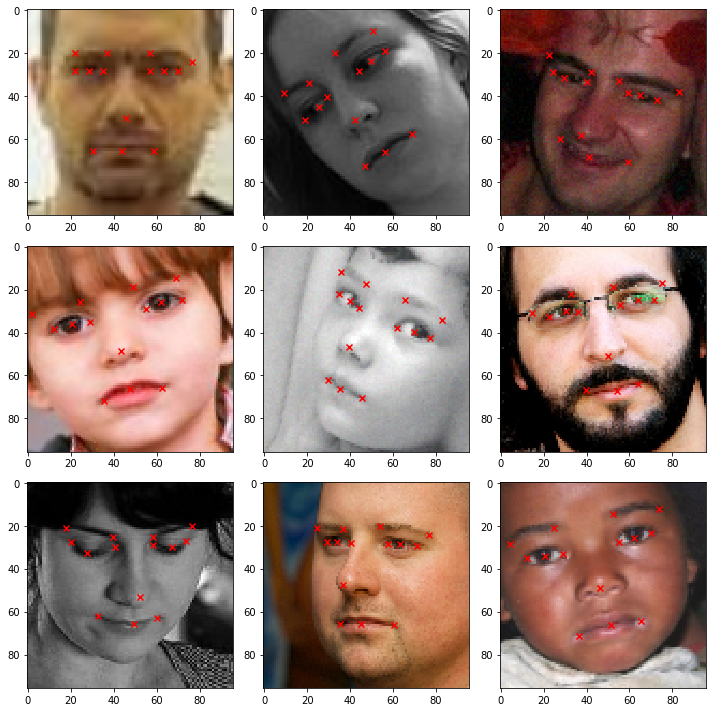

In [259]:
x_batch, y_batch = train_loader[1]
plot_samples(x_batch,y_batch)

## 3. Building a model

### 3.1 Baseline

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPool2D, BatchNormalization, Dropout, Activation, MaxPooling2D, Flatten,Conv2DTranspose,Input,Add
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU

Simple VGG-like convolutional neural network with batch normalization blocks to reduce overfitting

In [20]:
def build_model():
    model = Sequential(name="Baseline_CNN")
    
    # Input dimensions: (None, 96, 96, 3)
    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 96, 96, 32)
    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Input dimensions: (None, 48, 48, 32)
    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 48, 48, 64)
    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # Input dimensions: (None, 24, 24, 64)
    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 24, 24, 96)
    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Input dimensions: (None, 12, 12, 96)
    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 12, 12, 128)
    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # Input dimensions: (None, 6, 6, 128)
    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 6, 6, 256)
    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Input dimensions: (None, 3, 3, 256)
    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    # Input dimensions: (None, 3, 3, 512)
    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    # Input dimensions: (None, 3, 3, 512)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(28))
    
    return model

In [21]:
model = build_model()
model.summary()

Model: "Baseline_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 96, 96, 32)        864       
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 32)       

In [263]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

Loss function - Mean Squared Error

Optimizer - Adam, computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients

In [264]:
#Stop training when a monitored metric has stopped improving.
#patience - number of epochs with no improvement after which training will be stopped.
es = EarlyStopping(monitor='val_loss', patience=10)

#Callback to save the Keras model or model weights at some frequency.
mc = ModelCheckpoint('best_cnn_with_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer='Adam', 
              loss='mse', 
              metrics=['mae'])

In [ ]:
history = model.fit(train_loader,
                    steps_per_epoch=len(train_loader),
                    validation_data=(X_valid, y_valid),
                    epochs=30,
                    callbacks=[es, mc])

In [265]:
model.load_weights("keypoint_CNN_aug.h5")

In [266]:
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test MSE:', score[0])
print('Test MAE:', score[1])

1000/1000 [==============================] - 19s 19ms/step
Test MSE: 5.432542846679688
Test MAE: 1.7820751667022705


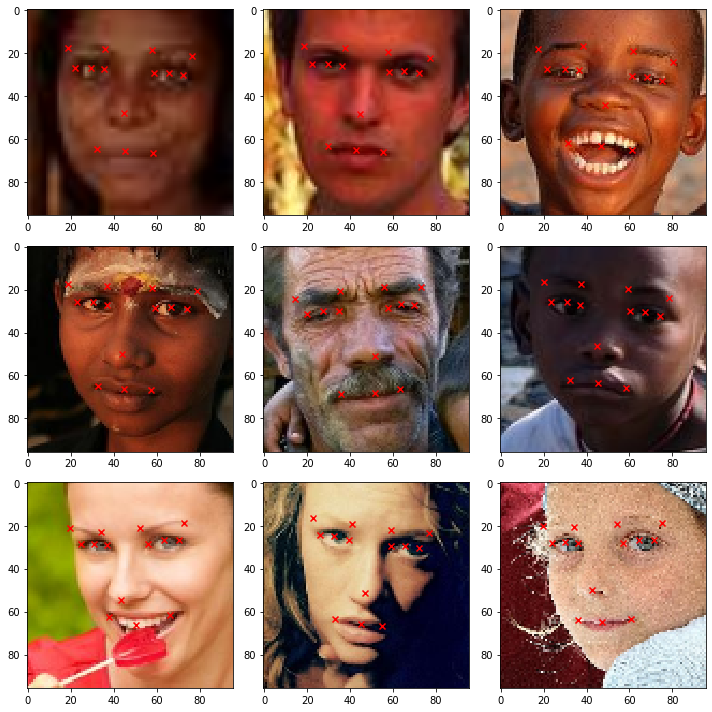

In [267]:
    pred_keypoints = model.predict(X_valid)
    plot_samples(X_valid,pred_keypoints)

In [269]:
def get_submission_images():
    """
    Uploading, normalizing and resizing submission images 
    Returns: array of submission images (5000,96,96,3)
    """
    submission_images = []
    image_names = []
    for file in os.listdir(_dir_test):
        img = cv2.imread(_dir_test + str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (img / 255).astype(np.float32)

        resized = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        submission_images.append(resized)
        image_names.append(str(file))
    return np.array(submission_images),np.array(image_names)

In [270]:
submission_images,names = get_submission_images()

In [271]:
def make_submission(submission_images,names):
    sub_keypoints = model.predict(submission_images)
    plot_samples(submission_images,sub_keypoints)
    df = pd.DataFrame(data=np.append(names[:,np.newaxis],sub_keypoints,axis=1),columns=column_names)
    df.to_csv("submission.csv")

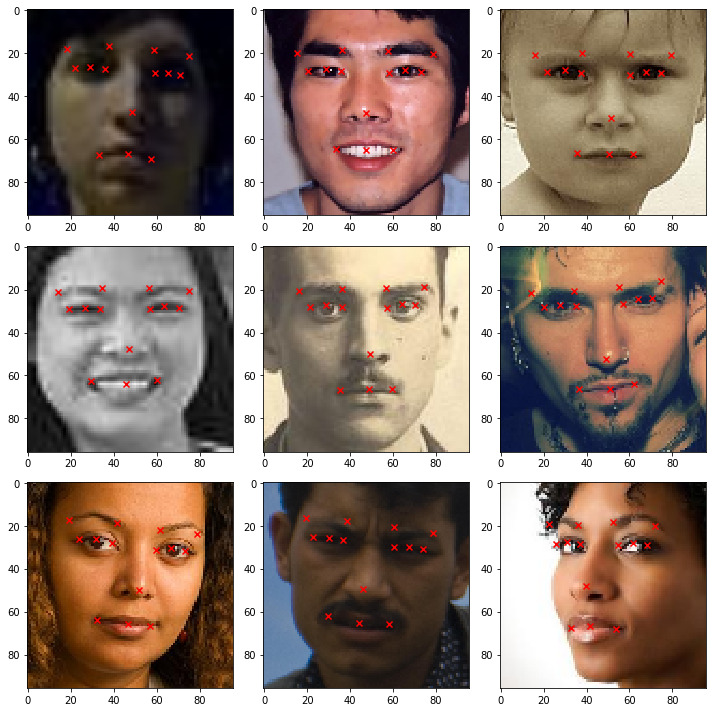

In [272]:
make_submission(submission_images,names)

### 3.2 EfficientNet

In [273]:
from efficientnet.keras import EfficientNetB0
from keras.applications import MobileNetV2
from keras.models import Model

Using more complex model from EfficientNet class - Current SOTA for image classification

In [274]:
def build_model():
    model = Sequential()
    eff_net = EfficientNetB0(weights=None,include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    eff_net.trainable = True
    model.add(eff_net)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(28))
    return model

In [275]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 3, 3, 1280)        4049564   
_________________________________________________________________
flatten_7 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               5898752   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 28)                14364     
Total params: 9,962,680
Trainable params: 9,920,664
Non-trainable params: 42,016
_________________________________________________________________


In [276]:
es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint('best_efficientNET_with_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer='Adam', 
              loss='mse', 
              metrics=['mae'])

In [ ]:
history = model.fit(train_loader,
                    steps_per_epoch=len(train_loader),
                    validation_data=(X_valid, y_valid),
                    epochs=30,
                    callbacks=[es, mc])

In [277]:
model.load_weights("best_efficientNET_with_aug.h5")

In [278]:
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test MSE:', score[0])
print('Test MAE:', score[1])

1000/1000 [==============================] - 19s 19ms/step
Test MSE: 13.98825133895874
Test MAE: 2.4602699279785156


### 3.3 Heatmap Regression

More complex approach: predicting each point location as a heatmap via semantic segmentation

To simplify transformation process we will perform augmentations just before we'll actually create heatmaps

In [279]:
def get_augmentation(images,keypoints,aug):
    """Returns transformed images and keypoints"""
    points = np.array([tuple(zip(point[::2], point[1::2])) for point in keypoints ])
    transformed = np.array([aug(image=x, keypoints=y) for x,y in zip(images, points)])
    X = np.array([tr['image'] for tr in transformed])
    Y = np.array([np.array(tr['keypoints']).flatten(order='C') for tr in transformed])
    return X,Y

In [280]:
transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=30,p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(1e-5, 1e-3), p=0.5),
],keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
)

X_aug,Y_aug = get_augmentation(train_images,train_keypoints,transform)
X_aug.shape,Y_aug.shape

((5000, 96, 96, 3), (5000, 28))

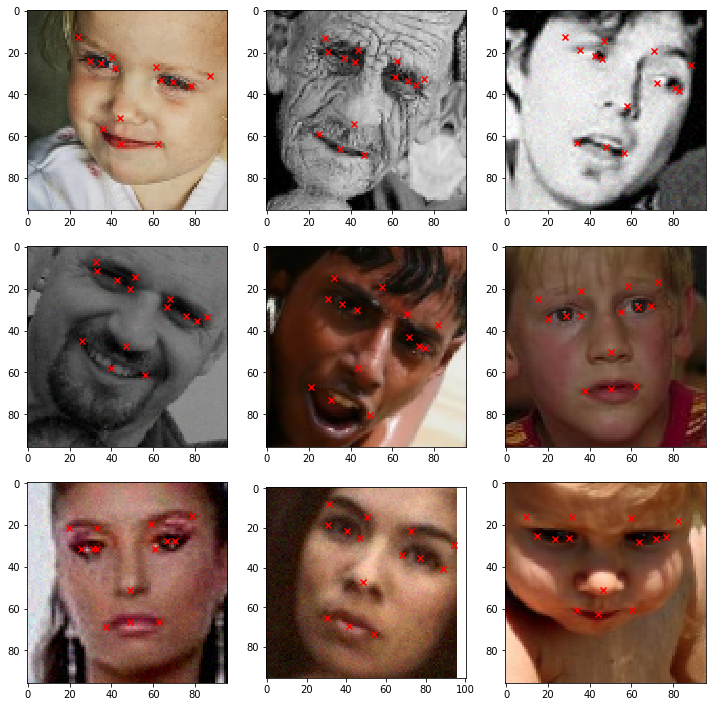

In [281]:
plot_samples(X_aug,Y_aug)

Merge augmented and actual images

In [282]:
train_images = np.concatenate([X_aug,train_images],axis=0)
train_keypoints = np.concatenate([Y_aug,train_keypoints],axis=0)
train_images.shape,train_keypoints.shape

((10000, 96, 96, 3), (10000, 28))

We need to create a "гауссианка" in the keypoint position

In the case of left eye keypoint, the Gaussian kernel centered around left eye keypoint $(
x_{\textrm{left eye keypoint}},
y_{\textrm{left eye keypoint}})$ has a value at (x,y) as:

$$\frac{1}{2\pi \sigma^2 } 
exp 
\left({-\frac{(x-x_{\textrm{left eye landmark}})^2 + (y-y_{\textrm{left eye keypoint}})^2}{2 \sigma^2}}\right)
$$

In [283]:
def gaussian_kernel(x0,y0,sigma,W,H):
    """
    Apply gaussian kernel
    Returns: heatmap of shape (W,H)
    """
    x = np.arange(0, W, 1, float) ## (width,)
    y = np.arange(0, H, 1, float)[:, np.newaxis] ## (height,1)
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

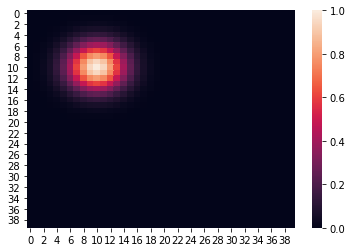

In [284]:
sns.heatmap(gaussian_kernel(10,10,3,40,40))

In [285]:
def generate_hm_sample(H,W,points,sigma):
    """
    Generate heatmaps for the 1 sample of data
    Returns: heatmap array, shape (H,W,num_points(14 in our case)) 
    """
    n_points = len(points)
    hm = np.zeros((H,W,n_points),dtype = np.float32)
    for i in range(n_points):
        hm[:,:,i] = gaussian_kernel(points[i][0],points[i][1],sigma,W,H)
    return hm

In [286]:
def generate_hm_data(y,H,W,sigma):
    """
    Transform all keypoint samples to heatmaps
    Returns: heatmaps array, shape (num_samples,H,W,num_keypoints(14 in our case)) 
    """
    y_train = []
    for sample in y:
        keypoints = np.array(tuple(zip(sample[0::2], sample[1::2])))
        y_train.append(generate_hm_sample(H,W,keypoints,sigma))
    return np.array(y_train)

In [287]:
sigma = 5
train_heatmaps = generate_hm_data(train_keypoints,IMG_SIZE,IMG_SIZE,sigma)
train_images.shape,train_keypoints.shape,train_heatmaps.shape

((10000, 96, 96, 3), (10000, 28), (10000, 96, 96, 14))

In [288]:
def plot_sample_with_hms(images,heatmaps,index):
    """Plot image and it's heatmaps"""
    fig = plt.figure(figsize=(80,20))
    ax = fig.add_subplot(2,7,1)
    ax.imshow(images[index])
    for i in range(14):
        ax = fig.add_subplot(2,8,i+2)
        ax.imshow(heatmaps[index,:,:,i],cmap='gray')    
    plt.show()

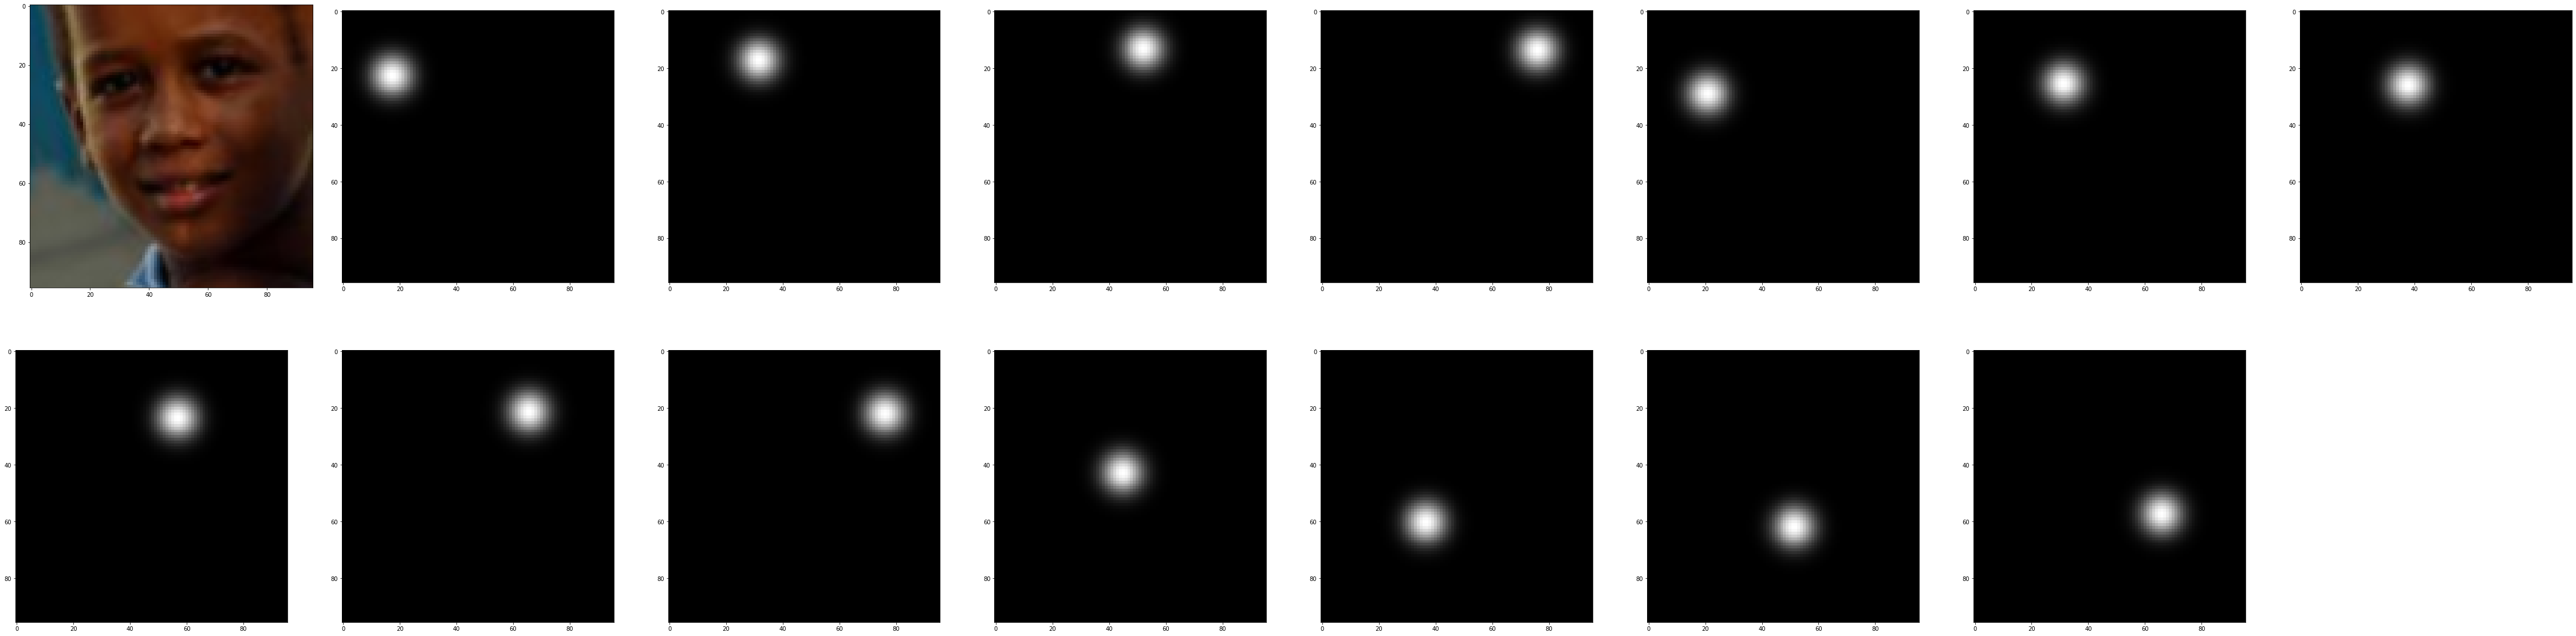

In [289]:
plot_sample_with_hms(train_images,train_heatmaps,1)

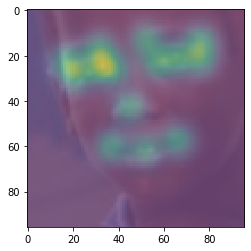

In [290]:
#Plot a single image overlayed with its heatmaps
plt.imshow(train_images[1], cmap='gray', alpha=0.5)
plt.imshow(train_heatmaps[1].sum(axis=2), alpha=0.5)

In [291]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_heatmaps, test_size=0.15, random_state=15,shuffle=True)
X_train.shape,y_train.shape,X_valid.shape

((8500, 96, 96, 3), (8500, 96, 96, 14), (1500, 96, 96, 3))

In [293]:
def conv_block(x,n_filters,kernel_size=(2,2),n_convs=2):
    """(Conv2d->LeakyReLU->BatchNorm)*N -> MaxPool"""
    for i in range(n_convs):
        x = Convolution2D(n_filters,kernel_size,padding='same', use_bias=False)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    
    return x

def build_model(num_classes):
    """
    Fully Convolutional Network
    
    Encode->Bottleneck->Decode
    Used FCN8-like structure, with reduced num of Conv blocks
    """
    input = Input((IMG_SIZE,IMG_SIZE,3))
    
    # Encode
    #Block1, output(48, 48, 64)
    x = conv_block(input,n_filters=64)
    
    #Block2, output(24, 24, 128)
    x = conv_block(x,n_filters=128)
    
    #We will fuse output of these layers before upsampling
    #Block3, output(12, 12, 512)  
    pool3 = conv_block(x,n_filters=256)
    
    #Block4, output(6, 6, 512) 
    pool4 = conv_block(pool3,n_filters=512)
    
    #Block5, output(3, 3, 512) 
    x = conv_block(pool4,n_filters=512)
    
    #Bottleneck
    #Block6, output(3, 3, 512) 
    x = Convolution2D(512,kernel_size=(1,1),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    #Block7, output(3, 3, 14) 
    x = Convolution2D(num_classes,kernel_size=(1,1),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    #Decode/UpSampling
    #Block8, output(12, 12, 14)
    output3pool = Convolution2D(num_classes,kernel_size=(1,1),padding='same',use_bias=False)(pool3)
    
    #Block9, output(6, 6, 14)
    output4pool = Convolution2D(num_classes,kernel_size=(1,1),padding='same',use_bias=False)(pool4)
    
    #Block10, output(12, 12, 14)
    up_pool4 = Conv2DTranspose(num_classes,kernel_size=(2,2),strides=2)(output4pool)
    
    #Block11, output(12, 12, 14)
    up_last_conv = Conv2DTranspose(num_classes,kernel_size=(4,4),strides=4)(x)
    
    #Block12, output(12, 12, 14)
    fusion = Add()([output3pool,up_pool4,up_last_conv])
    
    #Block13, output(96, 96, 14)
    output = Conv2DTranspose(num_classes,kernel_size=(8,8),strides=8,padding='same')(fusion)
    
    model = Model(input,output,name="FCN")
    return model

In [294]:
model = build_model(train_heatmaps.shape[-1])
model.summary()

Model: "FCN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 96, 96, 64)   768         input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_85 (LeakyReLU)      (None, 96, 96, 64)   0           conv2d_89[0][0]                  
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 96, 96, 64)   256         leaky_re_lu_85[0][0]             
________________________________________________________________________________________________

In [295]:
es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint('best_FCN_with_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer='Adam', 
              loss='mse')

In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=30,
                    callbacks=[es, mc])

In [296]:
model.load_weights('best_FCN_with_aug.h5')

In [297]:
model.evaluate(X_valid, y_valid, verbose=1)

1500/1500 [==============================] - 71s 47ms/step


0.003547498619183898

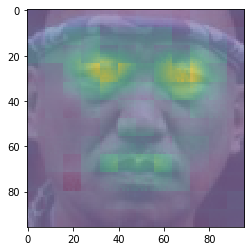

In [298]:
predicted = model.predict(X_valid)
plt.imshow(X_valid[1], cmap='gray', alpha=0.5)
plt.imshow(predicted[1].sum(axis=2), alpha=0.5)

In order to evaluate the model performance in terms of MSE on (x,y) coordinates, we need to transform heatmaps back to (x,y)

The possible solution is to get (x,y) of the pixel with the largest estimated density as the estimated coordinate.

In [299]:
def get_top_xy(heatmap):
    """Returns (x,y) of of the pixel with the largest value in heatmap"""
    return np.unravel_index(heatmap.argmax(), heatmap.shape)
    

In [300]:
def get_xy_sample(heatmaps):
    """Returns an array of xy's for each heatmap, shape=(N_keypoints,2)"""
    y = []
    for i in range(heatmaps.shape[-1]):
        y.append(get_top_xy(heatmaps[:,:,i]))
    return np.array(y)

In [301]:
def get_xy_predictions(samples):
    """
    Transform all heatmaps samples to xy arrays
    Returns: xy array, shape (num_samples,N_keypoints*2)
    """
    y_pred = []
    for hm_array in samples:
        pred = get_xy_sample(hm_array)
        pred = pred.reshape(-1)
        y_pred.append(pred)
    return np.array(y_pred)

In [302]:
y_pred = get_xy_predictions(predicted)
valid = get_xy_predictions(y_valid)
assert y_pred.shape == valid.shape

In [304]:
from sklearn.metrics import mean_squared_error

In [305]:
mean_squared_error(y_pred,valid)

26.85002380952381

The joke is, my laptop was able to train only 5 epohs, then kernel just died.